# 03 - Support Vector Machine
**Last Updated: 2022/04/13** <br>
**Support Vector Machine to predict the 6 sadness sub-emotions.**

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample

#tf-idf 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

#Packages that are typically not included in Jupyter and might need to be installed.
try:
    import pandas_profiling as pp
except:
    !pip install ipywidgets
    !pip install pandas-profiling
    import pandas_profiling as pp
    
!pip install openpyxl    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/keemia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Dataset

In [2]:
# Read in the database and csv file
anno2_r_path = "./02-anno2_r.xlsx"    #2-annotations, researcher focussed
anno2_p_path = "./02-anno2_p.xlsx"    #2-annotations, participant focussed
anno3_path = "./02-anno3.xlsx"    #3-annotations, balanced

df = pd.read_excel(anno2_r_path)
df

,ID,Tweet,ori_i,anno1_e,anno1_i,anno2_e,anno2_i
0,0,Depression sucks! #depression,0.958,depressed,3,depressed,2
1,1,Feeling worthless as always #depression,0.958,depressed,4,depressed,1
2,2,Feeling worthless as always,0.958,depressed,4,depressed,2
3,3,Im think ima lay in bed all day and sulk. Life...,0.934,depressed,5,depressed,4
4,4,So when I try I fail... and when I don't try.....,0.917,depressed,4,displeased,4
...,...,...,...,...,...,...,...
269,269,"Pops are joyless, soulless toys which look nea...",0.354,displeased,3,displeased,1
270,270,Why is it that we rejoice at a birth and griev...,0.354,depressed,3,displeased,2
271,271,Regret for the things we did can be tempered b...,0.354,hurt,1,guilty,3
272,272,In serious need of a nap,0.354,depressed,4,depressed,1


In [3]:
df_new = df[df['anno1_e'] == df['anno2_e']]
df_new

,ID,Tweet,ori_i,anno1_e,anno1_i,anno2_e,anno2_i
0,0,Depression sucks! #depression,0.958,depressed,3,depressed,2
1,1,Feeling worthless as always #depression,0.958,depressed,4,depressed,1
2,2,Feeling worthless as always,0.958,depressed,4,depressed,2
3,3,Im think ima lay in bed all day and sulk. Life...,0.934,depressed,5,depressed,4
5,5,my life in one word is depressing,0.917,depressed,3,depressed,3
...,...,...,...,...,...,...,...
262,262,No episode today! Whilst editing there was a p...,0.396,displeased,4,displeased,3
265,265,"the grave of a beat, a bravehearted cave lover...",0.375,depressed,1,depressed,2
267,267,I'm too sober time to get shit faced,0.360,depressed,4,depressed,4
269,269,"Pops are joyless, soulless toys which look nea...",0.354,displeased,3,displeased,1


In [4]:
#Quick check that all 6 sub-emotions are represented
df_new['anno1_e'].unique()

array(['depressed', 'displeased', 'grief', 'hurt', 'lonely', 'guilty'],
      dtype=object)

In [5]:
# Finding the number of similar annotations between anno1_e and anno2_e
df_new['anno1_e'].value_counts()

displeased    77
depressed     76
hurt           8
grief          7
lonely         6
guilty         1
Name: anno1_e, dtype: int64

## tf-idf Embedding

In [6]:
# Removing Stopwords
english_stop_words = set(stopwords.words('english'))

In [7]:
## Applying tf-idf - To Map tweets to numerical vetors
vectorizer = TfidfVectorizer(stop_words = english_stop_words)
X = vectorizer.fit_transform(df_new['Tweet'])
X

<175x938 sparse matrix of type '<class 'numpy.float64'>'
	with 1482 stored elements in Compressed Sparse Row format>

In [8]:
df_with_features = pd.DataFrame(X.todense())
df_with_features

,0,1,2,3,4,5,6,7,8,9,...,928,929,930,931,932,933,934,935,936,937
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_with_features['label'] = df_new['anno1_e'].values

## Support Vector Machine (SVM) Model

In [10]:
svm_model = SVC(kernel = 'linear') # 0.57 # it should be changed to KNN, RandomForest
#knn_model = KNeighborsClassifier(n_neighbors = 15) # 0.51
#dtree_model = DecisionTreeClassifier(max_depth = 10, random_state = 101) # 0.54 # Do better for depressed percision & displeased recall
X = df_with_features.drop(['label'], axis = 1)
y = df_with_features['label']
cross_val_predict(svm_model, X, y, cv = 5)

/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array(['depressed', 'depressed', 'depressed', 'depressed', 'depressed',
       'displeased', 'displeased', 'depressed', 'depressed', 'depressed',
       'depressed', 'depressed', 'displeased', 'depressed', 'displeased',
       'displeased', 'depressed', 'displeased', 'displeased', 'depressed',
       'displeased', 'depressed', 'depressed', 'displeased', 'depressed',
       'depressed', 'depressed', 'displeased', 'depressed', 'displeased',
       'depressed', 'depressed', 'displeased', 'displeased', 'depressed',
       'depressed', 'depressed', 'displeased', 'depressed', 'displeased',
       'grief', 'displeased', 'depressed', 'displeased', 'displeased',
       'displeased', 'depressed', 'depressed', 'depressed', 'displeased',
       'displeased', 'displeased', 'displeased', 'depressed',
       'displeased', 'depressed', 'displeased', 'displeased',
       'displeased', 'displeased', 'depressed', 'displeased', 'depressed',
       'depressed', 'displeased', 'displeased', 'depressed', 'dis

## Confusion Matirx

In [11]:
X = df_with_features.drop(['label'], axis = 1)
y = df_with_features['label']
svm_model.fit(X, y)

## Apllying 5-fold cross validation
predict_svc = pd.Series(cross_val_predict(svm_model, X, y, cv = 5))

## Generating Confusoin Matrix
conf_matrix_svc = confusion_matrix(y, predict_svc, labels = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty'])
print(conf_matrix_svc)

/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[[62 15  0  0  0  0]
 [34 42  0  0  0  0]
 [ 5  3  0  0  0  0]
 [ 4  2  0  0  0  0]
 [ 3  2  0  0  2  0]
 [ 1  0  0  0  0  0]]


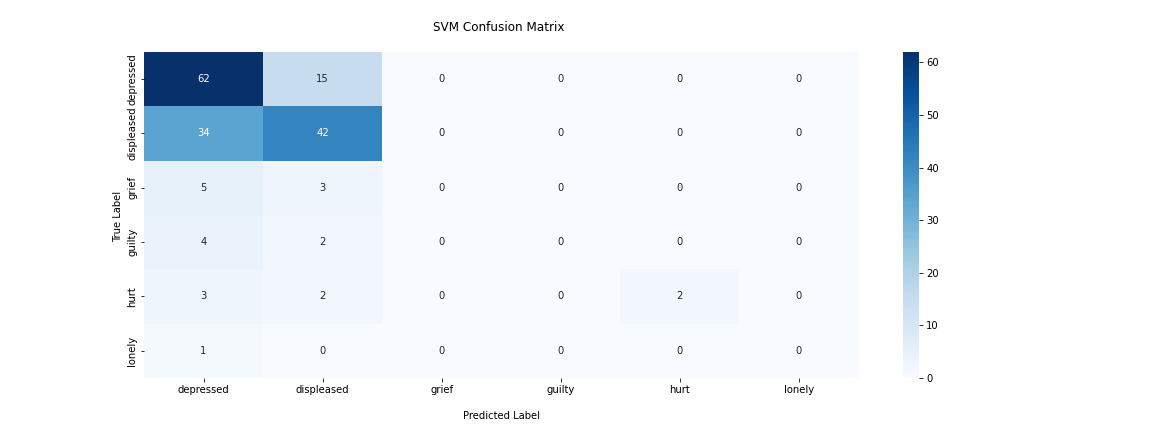

In [12]:
## Display the visualization of the Confusion Matrix.
fig = plt.figure(figsize = (16,6))

ax = sns.heatmap(conf_matrix_svc, annot = True, cmap = 'Blues')

ax.set_title('SVM Confusion Matrix \n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])
ax.yaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])

fig.savefig("svm_heatmap.png")
Image(filename = 'svm_heatmap.png')

## Accuracy Scores

In [13]:
## Classification Report
target_names = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty']
print(classification_report(y, predict_svc, target_names = target_names))

              precision    recall  f1-score   support

  displeased       0.66      0.55      0.60        76
   depressed       0.57      0.81      0.67        77
        hurt       1.00      0.29      0.44         7
      lonely       0.00      0.00      0.00         1
       grief       0.00      0.00      0.00         8
      guilty       0.00      0.00      0.00         6

    accuracy                           0.61       175
   macro avg       0.37      0.27      0.29       175
weighted avg       0.58      0.61      0.57       175



/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### The accuracy score for SVM Model is `61%`. As it is shown in the above Confusion Matrix, our SVM model does a decent job for `displeased` and `depressed` classification, while it does not do well for the other 4 sub-emotions. 

#### One interesting thing to mention here is the 34 displeased tweets that were classified as depressed. As we gathered our data ourselves, and based on our follow up interview with the participants, in some tweets, it was `hard to distinguish depressed vs dipleased tweets`.

#### One of the result of this result could be due to the fact that we gathered and labled data ourselves, therefore the data can have `noise`, and can be `unbalance`.

#### Another thing worth mentioning is that in our clean dataset (the data set that only have the common annotation in it) have `77 displeased`, `76 depressed`, `8 hurt`, `7 grief`, `6 lonely`, and `1 guilty`. Therefore, we have an unbalanced(skewed) data which can easlily affect the accouracy and precision of our models. 

#### As the result of all the mentioned notes, it's reasonable to say that our dataset is `not trustable` and `has not been confirmed by any experts in relavant fields` such as psychology.

In [14]:
## Prediction
sentence = ["Never leave me alone"]
X_test1 = vectorizer.transform(sentence)

svm_model.fit(X, y)
svm_model.predict(X_test1.todense())

/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array(['displeased'], dtype=object)

## Upsampling
#### As it is mentioned above, we have an `unbalanced dataset` and to handle the skewed data set we are going to try `upsampling approach` to see how our data set would work with this solution, and whether this is a trustable approach or not.
[Citation](https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/)

In [15]:
# Create separate dataframe for each sub-emotion
df_with_features_displeased = df_with_features[df_with_features['label'] == 'displeased']
df_with_features_depressed = df_with_features[df_with_features['label'] == 'depressed']
df_with_features_hurt = df_with_features[df_with_features['label'] == 'hurt']
df_with_features_grief = df_with_features[df_with_features['label'] == 'grief']
df_with_features_lonely = df_with_features[df_with_features['label'] == 'lonely']
df_with_features_guilty = df_with_features[df_with_features['label'] == 'guilty']

In [16]:
# Upsampling
# Citation: [https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/]

def custom_resample(df):
    return resample(df,
             replace=True,
             n_samples=len(df_with_features_displeased),
             random_state=42)

depressed_upsample = custom_resample(df_with_features_depressed)
hurt_upsample = custom_resample(df_with_features_hurt)
grief_upsample = custom_resample(df_with_features_grief)
lonely_upsample = custom_resample(df_with_features_lonely)
guilty_upsample = custom_resample(df_with_features_guilty)

In [17]:
# Create a new dataframe containing all sub-emotions
df_all_emotions = pd.concat([df_with_features_displeased, depressed_upsample, hurt_upsample, grief_upsample, lonely_upsample, guilty_upsample]).reset_index(drop = True)

# Shuffle the dataframe - to make sure that our algorithms are not biased in their prediction citation: [https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows]
df_all_emotions = df_all_emotions.sample(frac=1).reset_index(drop=True)
df_all_emotions


,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lonely
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lonely
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurt
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lonely
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,guilty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,depressed
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,displeased
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,guilty
460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,displeased


In [18]:
# Testing SVM Model
svm_model = SVC(kernel = 'linear')
X = df_all_emotions.drop(['label'], axis = 1)
y = df_all_emotions['label']

svm_model.fit(X, y)

## Apllying 5-fold cross validation
predict_svc = pd.Series(cross_val_predict(svm_model, X, y, cv = 5))

## Generating Confusoin Matrix
conf_matrix_svc = confusion_matrix(y, predict_svc, labels = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty'])
print(conf_matrix_svc)

[[71  5  0  1  0  0]
 [19 57  0  1  0  0]
 [ 0  0 77  0  0  0]
 [ 0  0  0 77  0  0]
 [ 0  0  0  0 77  0]
 [ 0  0  0  0  0 77]]


### Accuracy Scores - With Upsampling

In [19]:
## Classification Report
target_names = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty']
print(classification_report(y, predict_svc, target_names = target_names))

              precision    recall  f1-score   support

  displeased       0.92      0.74      0.82        77
   depressed       0.79      0.92      0.85        77
        hurt       1.00      1.00      1.00        77
      lonely       1.00      1.00      1.00        77
       grief       1.00      1.00      1.00        77
      guilty       0.97      1.00      0.99        77

    accuracy                           0.94       462
   macro avg       0.95      0.94      0.94       462
weighted avg       0.95      0.94      0.94       462



#### Since we had a small sample size for `hurt`, `lonely`, `grief`, `guilty` classes, and we're using the exact same data in the upsampling approach, it seems that our model is memorizing the tweets instead of learning from it. Due to this reason, we're getting higher accuracy (94%) for the SVM Model with Upsampling, but it is not trustable, since it seems that the reason behind this high accuracy is overfitting.

### Confusion Matrix - With Upsampling

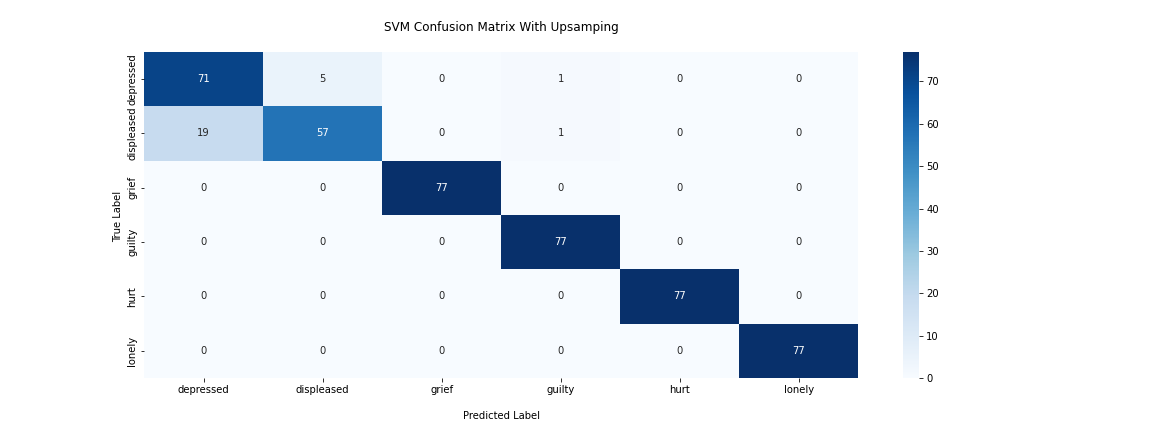

In [20]:
## Display the visualization of the Confusion Matrix.
fig = plt.figure(figsize = (16,6))

ax = sns.heatmap(conf_matrix_svc, annot = True, cmap = 'Blues')

ax.set_title('SVM Confusion Matrix With Upsamping\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])
ax.yaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])

fig.savefig("svm_heatmap_upsampling.png")
Image(filename = 'svm_heatmap_upsampling.png')

In [21]:
## Prediction
sentence = ["Never leave me alone"]
X_test1 = vectorizer.transform(sentence)

svm_model.fit(X, y)
svm_model.predict(X_test1.todense())

/Users/keemia/opt/miniconda3/envs/env_419/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array(['lonely'], dtype=object)

## Downsampling
#### As it is mentioned above, we have an `unbalanced dataset` and to handle the skewed data set we are going to try `downsampling approach` to see how our data set would work with this solution, and whether this is a trustable approach or not. 
[Citation](https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/)

In [22]:
# Create separate dataframe for each sub-emotion
df_with_features_displeased = df_with_features[df_with_features['label'] == 'displeased']
df_with_features_depressed = df_with_features[df_with_features['label'] == 'depressed']
df_with_features_hurt = df_with_features[df_with_features['label'] == 'hurt']
df_with_features_grief = df_with_features[df_with_features['label'] == 'grief']
df_with_features_lonely = df_with_features[df_with_features['label'] == 'lonely']
df_with_features_guilty = df_with_features[df_with_features['label'] == 'guilty']

In [23]:
# Down Sampling
# Citation: [https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/]

def custom_resample(df):
    return resample(df,
             replace=True,
             n_samples=len(df_with_features_lonely),
             random_state=42)

displeased_downsample = custom_resample(df_with_features_displeased)
depressed_downsample = custom_resample(df_with_features_depressed)
hurt_downsample = custom_resample(df_with_features_hurt)
grief_downsample = custom_resample(df_with_features_grief)
guilty_upsample = custom_resample(df_with_features_guilty)

In [24]:
# Create a new dataframe containing all sub-emotions
df_all_emotions = pd.concat([df_with_features_lonely, displeased_downsample, depressed_downsample, hurt_downsample, grief_downsample, guilty_upsample]).reset_index(drop = True)

# Shuffle the dataframe - to make sure that our algorithms are not biased in their prediction citation: [https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows]
df_all_emotions = df_all_emotions.sample(frac=1).reset_index(drop=True)
df_all_emotions


,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,hurt
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,lonely
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.427992,0.0,0.0,0.0,0.0,0.0,grief
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,depressed
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,guilty
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,hurt
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.427992,0.0,0.0,0.0,0.0,0.0,grief
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,guilty
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,hurt
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,displeased


In [25]:
# Testing SVM Model
svm_model = SVC(kernel = 'linear')
X = df_all_emotions.drop(['label'], axis = 1)
y = df_all_emotions['label']

svm_model.fit(X, y)

## Apllying 5-fold cross validation
predict_svc = pd.Series(cross_val_predict(svm_model, X, y, cv = 5))

## Generating Confusoin Matrix
conf_matrix_svc = confusion_matrix(y, predict_svc, labels = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty'])
print(conf_matrix_svc)

[[2 3 0 1 0 0]
 [2 2 0 2 0 0]
 [1 3 2 0 0 0]
 [1 3 1 1 0 0]
 [0 0 0 0 6 0]
 [0 0 0 0 0 6]]


### Accuracy Scores - With Downsampling

In [26]:
## Classification Report
target_names = ['displeased', 'depressed', 'hurt', 'lonely', 'grief', 'guilty']
print(classification_report(y, predict_svc, target_names = target_names))

              precision    recall  f1-score   support

  displeased       0.18      0.33      0.24         6
   depressed       0.33      0.33      0.33         6
        hurt       1.00      1.00      1.00         6
      lonely       1.00      1.00      1.00         6
       grief       0.67      0.33      0.44         6
      guilty       0.25      0.17      0.20         6

    accuracy                           0.53        36
   macro avg       0.57      0.53      0.54        36
weighted avg       0.57      0.53      0.54        36



#### Despite Upsampling, Downsampling approach seems more reasonable for our dataset. Since we only have `8 hurt`, `7 grief`, `6 lonely`, and `1 guilty` tweet in our cleaned dataset (The one that only has the tweets with similar annotations), downsampling for hurt, grief, lonely, and upsampling for guilty seems to be a more reasonable approch. As we see above, we get accuracy of 53% which is not that much below the SVM model accouracy that we had for the whole dataset, which was 61%.

### Confusion Matrix - With Downsampling

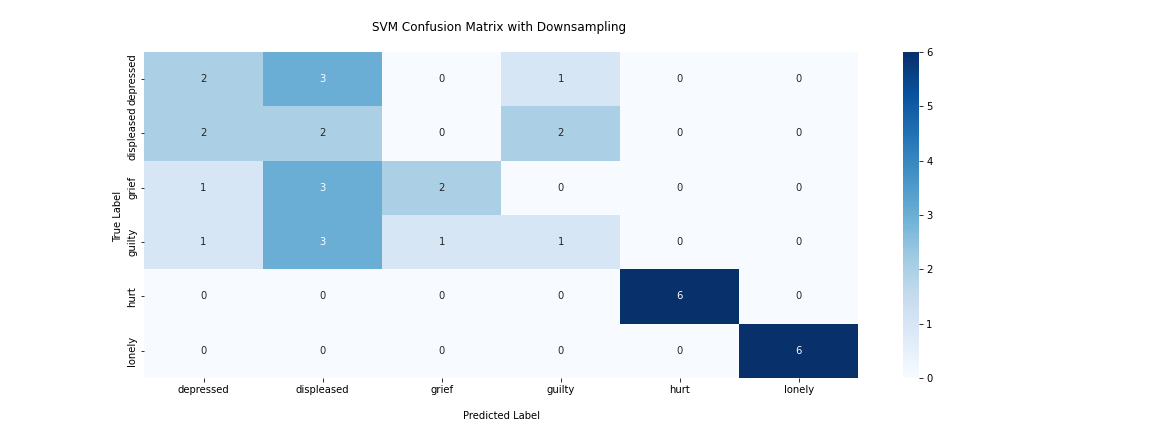

In [27]:
## Display the visualization of the Confusion Matrix.
fig = plt.figure(figsize = (16,6))

ax = sns.heatmap(conf_matrix_svc, annot = True, cmap = 'Blues')

ax.set_title('SVM Confusion Matrix with Downsampling \n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])
ax.yaxis.set_ticklabels(['depressed', 'displeased', 'grief', 'guilty', 'hurt', 'lonely' ])

fig.savefig("svm_heatmap_downsampling.png")
Image(filename = 'svm_heatmap_downsampling.png')